#Task II: Classical Graph Neural Network (GNN)
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.
● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
● Discuss the resulting performance of the 2 chosen architectures.


# We will use Pytorch Geometric Library

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00


In [ ]:
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, BCEWithLogitsLoss, Dropout, ModuleList
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy

energyflow: A library designed for energy flow analysis in particle physics, used in jet physics.

particle: Provides access to the particle data table from the Particle Data Group (PDG) for easy particle identification.

In [ ]:
!pip install energyflow
!pip install particle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.8/700.8 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.2/502.2 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
import energyflow
from particle import Particle

# Loading Dataset

In [ ]:
energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/data')
dataset = np.load(os.path.expanduser('~/data/datasets/QG_jets.npz'))

In [ ]:
dataset.files

['X', 'y']

Shape of dataset

In [ ]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((100000, 139, 4), (100000,))

 # Feature Engineering
In this cell, additional particle features are calculated using particle physics formulas.

pt, rapidity, and phi are extracted as basic kinematic features.

pdgids represent the particle ID according to the Particle Data Group (PDG).

mass is determined using the PDG data, only for particles with valid IDs.

The following derived features are computed:

Transverse Mass (mt) using the formula:
𝑚
𝑡
=
𝑚
2
+
𝑝
𝑡
2
m
t
​
 =
m
2
 +p
t
2
​

​


Energy (E) using the formula:
𝐸
=
𝑚
⋅
cosh
⁡
(
𝑦
)
E=m⋅cosh(y)

Momentum Components (px, py, pz) using:
𝑝
𝑥
=
𝑝
𝑡
⋅
cos
⁡
(
𝜙
)
,
𝑝
𝑦
=
𝑝
𝑡
⋅
sin
⁡
(
𝜙
)
,
𝑝
𝑧
=
𝑚
𝑡
⋅
sinh
⁡
(
𝑦
)
p
x
​
 =p
t
​
 ⋅cos(ϕ),p
y
​
 =p
t
​
 ⋅sin(ϕ),p
z
​
 =m
t
​
 ⋅sinh(y)

Finally, the engineered features are returned as a PyTorch tensor.

In [ ]:
def feature_engineer_dataset(X):

    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0)
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity)
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)

    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [ ]:
X_new = feature_engineer_dataset(X)
X_new.shape, X_new.type()

(torch.Size([100000, 139, 8]), 'torch.FloatTensor')

In [ ]:
torch.amax(X_new, dim=(0,1))

tensor([5.4849e+02, 2.2004e+00, 6.7172e+00, 1.0556e+03, 3.7837e+03, 5.0324e+02,
        5.2501e+02, 3.6537e+03])

In [ ]:
X_norm = X_new / torch.amax(X_new, dim=(0,1))
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.

In [ ]:
np.set_printoptions(suppress=True,precision=4)
X_norm[0,:,0], X_new[0,:,0]

(tensor([4.9001e-04, 2.9185e-04, 2.0943e-03, 7.5326e-03, 3.0921e-03, 3.9995e-03,
         2.9519e-03, 1.2019e-02, 6.8751e-03, 2.4579e-02, 7.4895e-03, 3.9464e-02,
         1.2353e-02, 2.4166e-02, 5.4395e-03, 6.8140e-02, 6.1149e-01, 8.0609e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

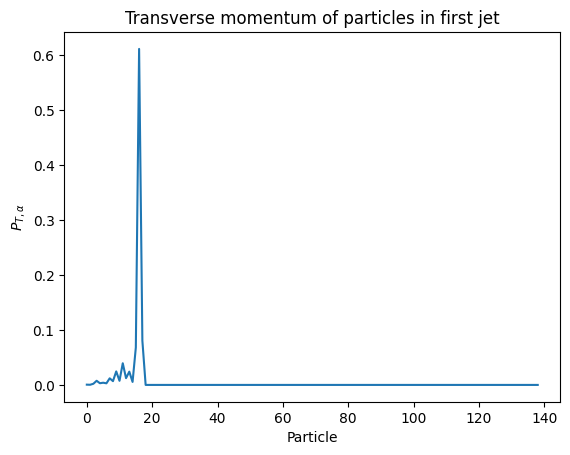

In [ ]:
n = X_norm[0].shape[0]
pt = X_norm[0,:,0]
plt.plot(range(n), pt)
plt.xlabel('Particle')
plt.ylabel('$P_{T,\\alpha}$')
plt.title('Transverse momentum of particles in first jet')
plt.show()

# Removing Unnecessary Particles
Since there are a lot of zeros in each jet (due to zero padding), we will remove the unnecessary particles form the dataset. Moreover, GNNs can handle graph data with different number of nodes, hence this will not cause any problems with training the GNN later

In [ ]:
def strip_zeros(X):
    X_useful = []
    for Xi in X:
        inds = np.where(Xi[:,0] != 0)
        X_useful.append(Xi[inds])

    return X_useful

In [ ]:
X_preprocessed = strip_zeros(X_norm)
len(X_preprocessed), X_preprocessed[0].shape, X_preprocessed[1].shape

(100000, torch.Size([18, 8]), torch.Size([17, 8]))

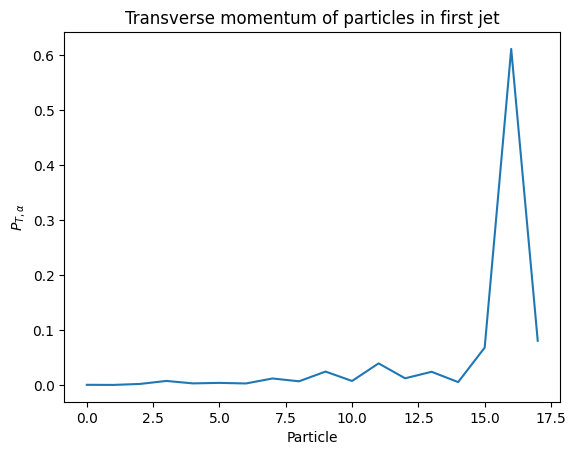

In [ ]:
n = X_preprocessed[0].shape[0]
pt = X_preprocessed[0][:,0]
plt.plot(range(n), pt)
plt.xlabel('Particle')
plt.ylabel('$P_{T,\\alpha}$')
plt.title('Transverse momentum of particles in first jet')
plt.show()

In [ ]:
X_preprocessed[0].dtype

torch.float32

In [ ]:
np.set_printoptions(suppress=False)

# Conversion to Graph Model
To convert this tabular data into a graph model, the following was considered:

*  **x** - Node features
*   **edge_index** - Edges (denoted by nodes forming the edges) of the graph of shape [2, num_edges] (COO format)

*   **edge_attr** - Edge features
*   **y** - Graph labels






In [ ]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(int(np.sqrt(M))+1, M)   # number of neighbors of each node to be considered for edge connections (1 extra for self loops)
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))
    edge_attr = torch.zeros((M*N, 1))

    for i,features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]

        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)

    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

# Test The function

In [ ]:
x = torch.tensor([[0,1,2],[0,3,4],[0,7,8],[0,4.5,4.5]])
edge_index, edge_attr = create_graph(x)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=[0])

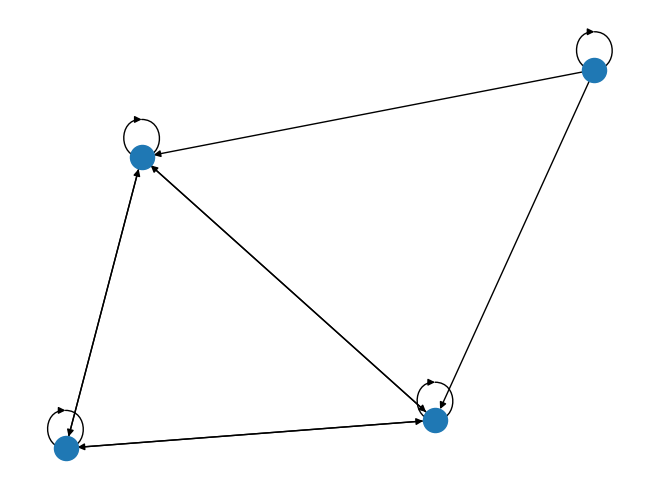

In [ ]:
g = to_networkx(data, to_undirected=False)
nx.draw(g)

In [ ]:
edge_index.dtype

torch.int32

In [ ]:
def create_graph_dataset(X, y):
    dataset = []

    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=yi)
        dataset.append(data)

    return dataset

dataset = create_graph_dataset(X_preprocessed,y)

len(dataset), dataset[0]

(100000, Data(x=[18, 8], edge_index=[2, 90], edge_attr=[90, 1], y=1.0))

# HperParameters

In [ ]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
batch_size = 256

epochs = 10
lr = 5e-4

In [ ]:
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])
len(data_train), len(data_val), len(data_test)

(60000, 20000, 20000)

In [ ]:
train_dataloader = DataLoader(data_train, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(data_val,batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(data_test,batch_size = batch_size, shuffle=True)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(235, 79, 79)

# GCN - Graph Convolutional Network




*   Graph convolution layer
*   Linear layer
*   Non-linear activation





In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GCNConv(input_dim, hidden_dims[0]))

        for i in range(len(hidden_dims)-1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.dropout = Dropout()
        self.classifier = Linear(hidden_dims[-1], output_dim)

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.dropout(h)
        h = self.classifier(h)
        return h

In [ ]:
model = GNN(input_dim = dataset[0].num_node_features, hidden_dims=[16,16,8],output_dim=1, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 8)
  )
  (activ_fn): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True):
    if train:
        model.train()
    else:
        model.eval()

    loss = 0
    net_loss = 0
    correct = 0

    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):

        target = data.y

        #This will zero out the gradients for this batch.
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float()
        correct += (pred == target).sum()


    acc = 100. * correct / len(loader.dataset)
    net_loss /= len(loader.dataset)

    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")

    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          acc))

    return net_loss, acc

In [ ]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):

    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    return history

In [ ]:
model = GNN(input_dim = dataset[0].num_node_features, hidden_dims=[16,16,8],output_dim=1, activ_fn=ReLU())
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

235it [00:11, 20.62it/s]


Train Epoch: 0 	Loss: 0.694963, Accuracy: 30241/60000 (50%)
Val Epoch: 0 	Loss: 0.700932, Accuracy: 9819/20000 (49%)



235it [00:11, 20.93it/s]


Train Epoch: 1 	Loss: 0.693438, Accuracy: 30942/60000 (52%)
Val Epoch: 1 	Loss: 0.696398, Accuracy: 11320/20000 (57%)



235it [00:11, 21.26it/s]


Train Epoch: 2 	Loss: 0.682941, Accuracy: 33824/60000 (56%)
Val Epoch: 2 	Loss: 0.671982, Accuracy: 13606/20000 (68%)



235it [00:11, 20.88it/s]


Train Epoch: 3 	Loss: 0.645899, Accuracy: 38710/60000 (65%)
Val Epoch: 3 	Loss: 0.610317, Accuracy: 14870/20000 (74%)



235it [00:11, 20.22it/s]


Train Epoch: 4 	Loss: 0.603367, Accuracy: 41978/60000 (70%)
Val Epoch: 4 	Loss: 0.565989, Accuracy: 15186/20000 (76%)



235it [00:11, 20.90it/s]


Train Epoch: 5 	Loss: 0.584962, Accuracy: 42866/60000 (71%)
Val Epoch: 5 	Loss: 0.553307, Accuracy: 15227/20000 (76%)



235it [00:11, 21.27it/s]


Train Epoch: 6 	Loss: 0.576881, Accuracy: 43348/60000 (72%)
Val Epoch: 6 	Loss: 0.543973, Accuracy: 15239/20000 (76%)



235it [00:11, 20.84it/s]


Train Epoch: 7 	Loss: 0.575800, Accuracy: 43472/60000 (72%)
Val Epoch: 7 	Loss: 0.537935, Accuracy: 15362/20000 (77%)



235it [00:11, 20.51it/s]


Train Epoch: 8 	Loss: 0.568146, Accuracy: 43584/60000 (73%)
Val Epoch: 8 	Loss: 0.534029, Accuracy: 15390/20000 (77%)



235it [00:11, 20.49it/s]


Train Epoch: 9 	Loss: 0.569545, Accuracy: 43584/60000 (73%)
Val Epoch: 9 	Loss: 0.533072, Accuracy: 15377/20000 (77%)



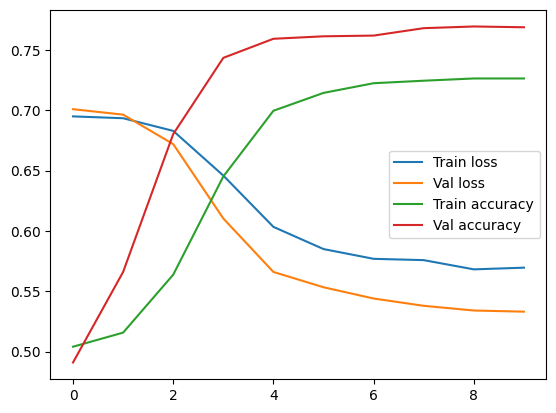

In [ ]:
x = range(epochs)
plt.plot(x, history['train_loss'], label='Train loss')
plt.plot(x, history['val_loss'], label='Val loss')
plt.plot(x, np.array(history['train_acc'])/100, label='Train accuracy')
plt.plot(x, np.array(history['val_acc'])/100, label='Val accuracy')

plt.legend()
plt.show()

# Test accuracy

In [ ]:
preds = []
labels = []
acc = 0
for data in test_dataloader:

    target = data.y
    labels += target

    output = model(data.x, data.edge_index, data.batch)
    probs = Sigmoid()(output).detach()
    preds += copy.deepcopy(probs)

    target = target.unsqueeze(1).float()
    pred = (output > 0).float()
    acc += (pred == target).sum()

acc = 100. * acc / len(test_dataloader.dataset)
print(acc)

tensor(76.3200)


# GNN_Sage


In [ ]:
class GNN_Sage(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(SAGEConv(input_dim, hidden_dims[0]))

        for i in range(len(hidden_dims)-1):
            layers.append(SAGEConv(hidden_dims[i], hidden_dims[i+1]))

        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.dropout = Dropout()
        self.classifier = Linear(hidden_dims[-1], output_dim)

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)

        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.dropout(h)
        h = self.classifier(h)
        return h
model = GNN_Sage(input_dim = dataset[0].num_node_features, hidden_dims=[16,16,8],output_dim=1, activ_fn=ReLU())
model

GNN_Sage(
  (layers): ModuleList(
    (0): SAGEConv(8, 16, aggr=mean)
    (1): SAGEConv(16, 16, aggr=mean)
    (2): SAGEConv(16, 8, aggr=mean)
  )
  (activ_fn): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-12)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

235it [00:08, 28.56it/s]


Train Epoch: 0 	Loss: 0.692142, Accuracy: 31167/60000 (52%)
Val Epoch: 0 	Loss: 0.683136, Accuracy: 12228/20000 (61%)



235it [00:08, 27.72it/s]


Train Epoch: 1 	Loss: 0.619804, Accuracy: 39449/60000 (66%)
Val Epoch: 1 	Loss: 0.542403, Accuracy: 15446/20000 (77%)



235it [00:08, 29.26it/s]


Train Epoch: 2 	Loss: 0.565490, Accuracy: 43382/60000 (72%)
Val Epoch: 2 	Loss: 0.524921, Accuracy: 15471/20000 (77%)



235it [00:08, 27.02it/s]


Train Epoch: 3 	Loss: 0.557762, Accuracy: 44107/60000 (74%)
Val Epoch: 3 	Loss: 0.516977, Accuracy: 15543/20000 (78%)



235it [00:07, 29.47it/s]


Train Epoch: 4 	Loss: 0.558820, Accuracy: 44112/60000 (74%)
Val Epoch: 4 	Loss: 0.517411, Accuracy: 15530/20000 (78%)



235it [00:07, 30.24it/s]


Train Epoch: 5 	Loss: 0.554399, Accuracy: 44209/60000 (74%)
Val Epoch: 5 	Loss: 0.514495, Accuracy: 15469/20000 (77%)



235it [00:07, 31.24it/s]


Train Epoch: 6 	Loss: 0.559159, Accuracy: 44025/60000 (73%)
Val Epoch: 6 	Loss: 0.516421, Accuracy: 15433/20000 (77%)



235it [00:07, 29.97it/s]


Train Epoch: 7 	Loss: 0.555038, Accuracy: 44257/60000 (74%)
Val Epoch: 7 	Loss: 0.514097, Accuracy: 15466/20000 (77%)



235it [00:07, 29.42it/s]


Train Epoch: 8 	Loss: 0.550923, Accuracy: 44385/60000 (74%)
Val Epoch: 8 	Loss: 0.516299, Accuracy: 15501/20000 (78%)



235it [00:08, 28.74it/s]


Train Epoch: 9 	Loss: 0.552544, Accuracy: 44242/60000 (74%)
Val Epoch: 9 	Loss: 0.512553, Accuracy: 15490/20000 (77%)



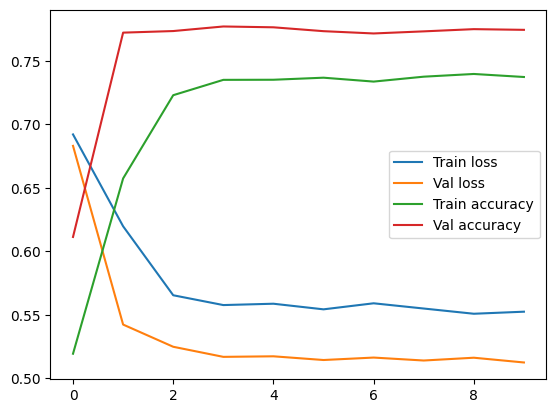

In [ ]:
x = range(epochs)
plt.plot(x, history['train_loss'], label='Train loss')
plt.plot(x, history['val_loss'], label='Val loss')
plt.plot(x, np.array(history['train_acc'])/100, label='Train accuracy')
plt.plot(x, np.array(history['val_acc'])/100, label='Val accuracy')

plt.legend()
plt.show()

# Test accuracy

In [ ]:
preds = []
labels = []
acc = 0
for data in test_dataloader:

    target = data.y
    labels += target

    output = model(data.x, data.edge_index.type(torch.int64), data.batch)
    probs = Sigmoid()(output).detach()
    preds += copy.deepcopy(probs)

    target = target.unsqueeze(1).float()
    pred = (output > 0).float()
    acc += (pred == target).sum()

acc = 100. * acc / len(test_dataloader.dataset)
print(acc)

tensor(77.6100)


# Discuss the resulting performance of the 2 chosen architectures.
 Accuracy of GCN came out to be 76 % and
 Accuracy of GSAGE is 77 %

 There is not much difference in the accuracy of these two
